In [16]:
import pandas as pd
import numpy as np
import os
import shutil
import glob

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.resnet import preprocess_input, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten , Dense
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
import tensorflow as tf


In [5]:
TRAIN_PATH  = "./archive/training"
VALID_PATH  = "./archive/validation"
TEST_PATH   = "./archive/evaluation"
TARGET_SIZE = (224,224)
BATCH_SIZE = 16

In [6]:
objTrainGenerator = ImageDataGenerator(rescale=1. / 255)

objTrain = objTrainGenerator.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 9866 images belonging to 11 classes.


In [7]:
objValidGenerator = ImageDataGenerator(rescale=1. / 255)

objValid = objValidGenerator.flow_from_directory(
    VALID_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 3430 images belonging to 11 classes.


In [8]:
objTestGenerator = ImageDataGenerator(rescale=1./255)

objTest = objTestGenerator.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 3347 images belonging to 11 classes.


In [9]:
import efficientnet.tfkeras as efn

base_model = efn.EfficientNetB7(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [10]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

num_classes = 11

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
x=Dense(64,activation='relu')(x) 
out=Dense(num_classes,activation='softmax')(x)

objModel=Model(inputs=base_model.input,outputs=out)
base_model.trainable = False
objModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [11]:
num_epochs = 30
STEP_SIZE_TRAIN=objTrain.n//objTrain.batch_size
STEP_SIZE_VALID=objValid.n//objValid.batch_size
STEP_SIZE_TEST =objTest.n//objTest.batch_size

modelCheckpoint = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [9]:
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

objFit = objModel.fit(objTrain, steps_per_epoch= STEP_SIZE_TRAIN, epochs= num_epochs, validation_data=objValid , validation_steps= STEP_SIZE_VALID, callbacks=[modelCheckpoint])

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Epoch 1/30
616/616 [==============================] - 379s 529ms/step - loss: 1.3221 - accuracy: 0.5665 - val_loss: 0.6337 - val_accuracy: 0.7961

Epoch 00001: val_accuracy improved from -inf to 0.79614, saving model to bestmodel.h5
Epoch 2/30
616/616 [==============================] - 153s 249ms/step - loss: 0.8105 - accuracy: 0.7290 - val_loss: 0.5654 - val_accuracy: 0.8151

Epoch 00002: val_accuracy improved from 0.79614 to 0.81513, saving model to bestmodel.h5
Epoch 3/30
616/616 [==============================] - 153s 249ms/step - loss: 0.6490 - accuracy: 0.7755 - val_loss: 0.5278 - val_accuracy: 0.8254

Epoch 00003: val_accuracy improved from 0.81513 to 0.82535, saving model to bestmodel.h5
Epoch 4/30
616/616 [==============================] - 153s 249ms/step - loss: 0.6467 - accuracy: 0.7856 - val_loss: 0.5037 - val_accuracy: 

In [12]:
objModel = load_model("bestmodel.h5")

loss, acc = objModel.evaluate(objTest, steps=STEP_SIZE_TEST)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}".format(acc,loss))

209/209 [==============================] - 68s 233ms/step - loss: 0.3715 - accuracy: 0.8879
The accuracy of the model is 0.888
The Loss in the model is 0.371


In [13]:
true_classes = objTest.classes
class_labels = list(objTest.class_indices.keys())   

predictions = objModel.predict_generator(objTest)
predictions = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predictions, target_names=class_labels)
print(report)    

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                 precision    recall  f1-score   support

          Bread       0.86      0.85      0.85       368
  Dairy product       0.88      0.76      0.82       148
        Dessert       0.85      0.84      0.84       500
            Egg       0.86      0.85      0.86       335
     Fried food       0.87      0.86      0.87       287
           Meat       0.90      0.90      0.90       432
  Noodles-Pasta       0.95      0.99      0.97       147
           Rice       0.89      0.97      0.93        96
        Seafood       0.86      0.90      0.88       303
           Soup       0.95      0.96      0.96       500
Vegetable-Fruit       0.93      0.93      0.93       231

       accuracy                           0.89      3347
      macro avg       0.89      0.89      0.89      3347
   weighted avg       0.89      0.89      0.89      3347



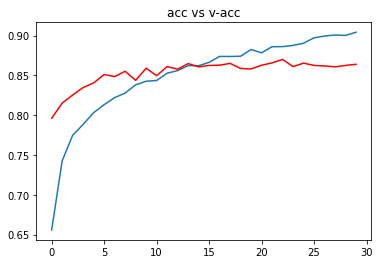

In [12]:
objHistory = objFit.history

plt.plot(objHistory['accuracy'])
plt.plot(objHistory['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

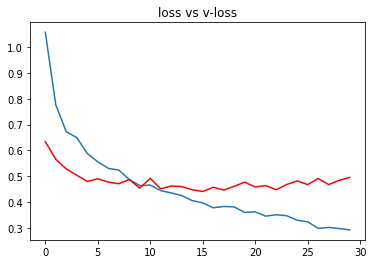

In [13]:
objHistory = objFit.history

plt.plot(objHistory['loss'])
plt.plot(objHistory['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

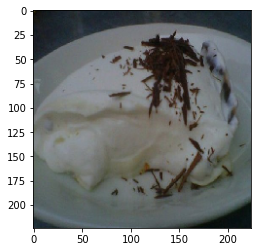

Classificado como: Dessert
81920/81500 [==============================] - 0s 0us/step


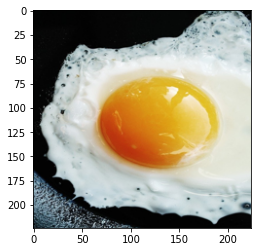

99.99191761016846 Egg


In [54]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np


x = objTest.next()

objImage = x[0]
plt.imshow(objImage[1])
plt.show()

def Get_Best(objImage):
    j = 0
    best = 0
    bestPosition = 0
    for image in objModel.predict(objImage)[0]:
        percent = image*100 
    
        if percent > best:
            best = percent
            bestPosition = j
        
        j+=1
        
    return best, bestPosition
    
    
labels = list(objTest.class_indices.keys())

best, bestPosition = Get_Best(objImage)
print("Classificado como:", labels[bestPosition])

from PIL import Image
import requests
from io import BytesIO
import uuid

ds_URL = "https://www.sophisticatedgourmet.com/wp-content/uploads/2021/01/how-to-fry-an-egg-recipe.jpg"
objImageUrl = tf.keras.utils.get_file(str(uuid.uuid4()) + '.jpg', ds_URL)
objImageUrl = Image.open(objImageUrl).resize((224,224))

plt.imshow(objImageUrl)
plt.show()

best, bestPosition = Get_Best(np.expand_dims(objImageUrl, axis=0)/255)
print(best, labels[bestPosition])